This code is based on the Flow Down Slope notebook in the flowdownslope example. It contains quick analysis for the abyssal mixing case.

In [73]:
%pylab inline
import scipy.io.netcdf
import time
import scipy.interpolate as interp
import matplotlib.gridspec as gridspec
from IPython import display
# These next two lines add the MOM6-examples/tools/analysis/ directory to the search path for python packages
import sys
sys.path.append('../../tools/analysis/')
# m6toolbox is a python package that has a function that helps visualize vertical sections
import m6toolbox

fname = scipy.io.netcdf_file('prog.nc')
gname = scipy.io.netcdf_file('ocean_geometry.nc')
#fname = scipy.io.netcdf_file('ABMIX_runs/run0002.nc')
#gname = scipy.io.netcdf_file('ABMIX_runs/run0002_geometry.nc')
# Read in coordinate arrays and others:
yq = fname.variables['yq'][:] # This is the coordinate of the cell corners (u-points in 1D)
yq = yq-yq[0]+(yq[1]-yq[0]) # Adjust so 0 is the left side
yq = numpy.concatenate(([0],yq)) # Inserts left most edge of domain in to coordinates
yh = fname.variables['yh'][:]
yh = yh-yh[0]+(yh[1]-yh[0])/2 #Adjust so 0 is the left side
A = gname.variables['Ah'][:] # Area at T points
rhoi = fname.variables['zi'][:] # rho at interfaces
rhol = fname.variables['zl'][:] # rho at layers
bathyT = gname.variables['D'][:,0] #Bathymetry
yL = len(bathyT) # ypoints
zL = len(rhoi)-1 # number of layers
# Define a function to plot a section
def plot_section(file_handle, record, variable='zl', clim=(1035., 1036.), plot_grid=True, rep='linear'):
    """Plots a section of by reading vertical grid and scalar variable and super-sampling
    both in order to plot vertical and horizontal reconstructions.
    
    Optional arguments have defaults for plotting salinity and overlaying the grid.
    """
    e = file_handle.variables['e'][record,:,:,0] # Vertical grid positions
    if variable == 'zl':
        s = np.tile(file_handle.variables['zl'][:],(len(e[0,:]),1)).T
    else:
        s = file_handle.variables[variable][record,:,:,0] # Scalar field to color

    if (np.shape(s)[0]==np.shape(e)[0]):
        s = (s[1:,:]+s[:-1,:])/2 #NOTE THIS IS DODGY!
    y,z,q = m6toolbox.section2quadmesh(yq, e, s, representation=rep) # This yields three areas at twice the model resolution
    plt.pcolormesh(y, z, q);
    plt.clim(clim)
    if plot_grid: plt.plot(y, z.T, 'k', hold=True);
    plt.ylim(-4000,400)
    plt.xlim(-10.,810.)
    
def moving_average(a, n=3):
    if (np.mod(n,2)):  
        n=n+1
    out = nan*np.zeros_like(a)
    for i in range((n-1)/2,len(a)-(n-1)/2):
        out[i] = np.mean(a[i-(n-1)/2:i+(n-1)/2+1])
    return out

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy
/home/z3500785/anaconda3/lib/python3.5/site-packages/scipy/io/netcdf.py:297: RuntimeWarning: Cannot close a netcdf_file opened with mmap=True, when netcdf_variables or arrays referring to its data still exist. All data arrays obtained from such files refer directly to data on disk, and must be copied before the file can be cleanly closed. (See netcdf_file docstring for more information on mmap.)
  ), category=RuntimeWarning)


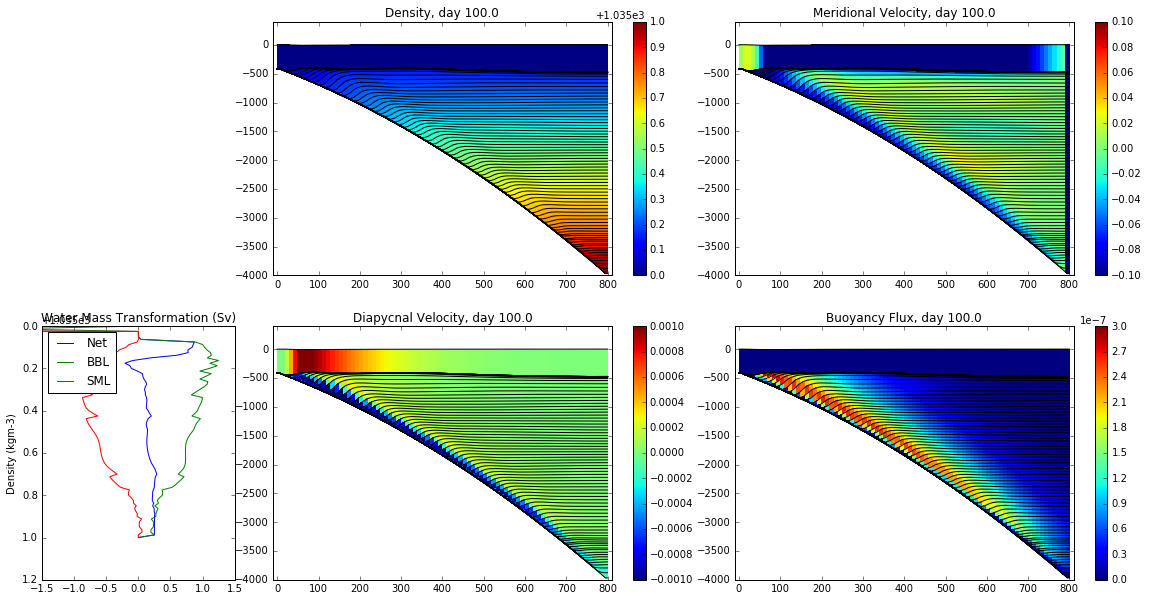

In [74]:
# Plot y-z section at a given time, or make a movie:   
record = -1 # record
hBL = 150.0 #BBL depth for epsBBL and epsSML
fig = plt.figure(1, figsize=(20,10))
timevar = fname.variables['Time']
for record in [record]:
#for record in np.arange(0,len(timevar[:]),10):
    plt.clf()
    plt.subplot2grid((2,5),(1,0))
    wd = fname.variables['wd'][record,:,:,0];e = fname.variables['e'][record,:,:,0];
    epsNET = -np.dot(wd,A[:,0])*len(A[0,:])
    wdcp = np.copy(wd);wdcp[e+np.tile(bathyT,[zL+1,1])<hBL] = 0.0;
    epsSML = -np.dot(wdcp,A[:,0])*len(A[0,:])
    wdcp = np.copy(wd);wdcp[e+np.tile(bathyT,[zL+1,1])>=hBL] = 0.0;
    epsBBL = -np.dot(wdcp,A[:,0])*len(A[0,:])
    plt.plot(epsNET/1e6,rhoi, label='Net'); plt.plot(epsBBL/1e6,rhoi, label='BBL'); plt.plot(epsSML/1e6,rhoi, label='SML'); plt.gca().invert_yaxis();
    plt.title('Water Mass Transformation (Sv)'); plt.ylabel('Density (kgm-3)'); plt.legend(loc=2); plt.xlim([-1.5, 1.5])
    plt.subplot2grid((2,5),(0,1),colspan=2)
    plot_section(fname, record, variable='zl', clim=(1035.0, 1036.0)); plt.title('Density, day {}'.format(timevar[record])); plt.colorbar()
    plt.subplot2grid((2,5),(0,3),colspan=2)
    plot_section(fname, record, variable='v', clim=(-0.1, 0.1)); plt.title('Meridional Velocity, day {}'.format(timevar[record])); plt.colorbar()
    plt.subplot2grid((2,5),(1,1),colspan=2)
    plot_section(fname, record, variable='wd', clim=(-0.001, 0.001)); plt.title('Diapycnal Velocity, day {}'.format(timevar[record])); plt.colorbar()
    plt.subplot2grid((2,5),(1,3),colspan=2)
    plot_section(fname, record, variable='buoyancy_flux', clim=(0.0, 3.0e-7)); plt.title('Buoyancy Flux, day {}'.format(timevar[record])); plt.colorbar()
    #plt.savefig('frame{:04d}'.format(record))
#plt.savefig('steady5krun_day5000')

In [66]:
np.shape(rhol)


(40,)

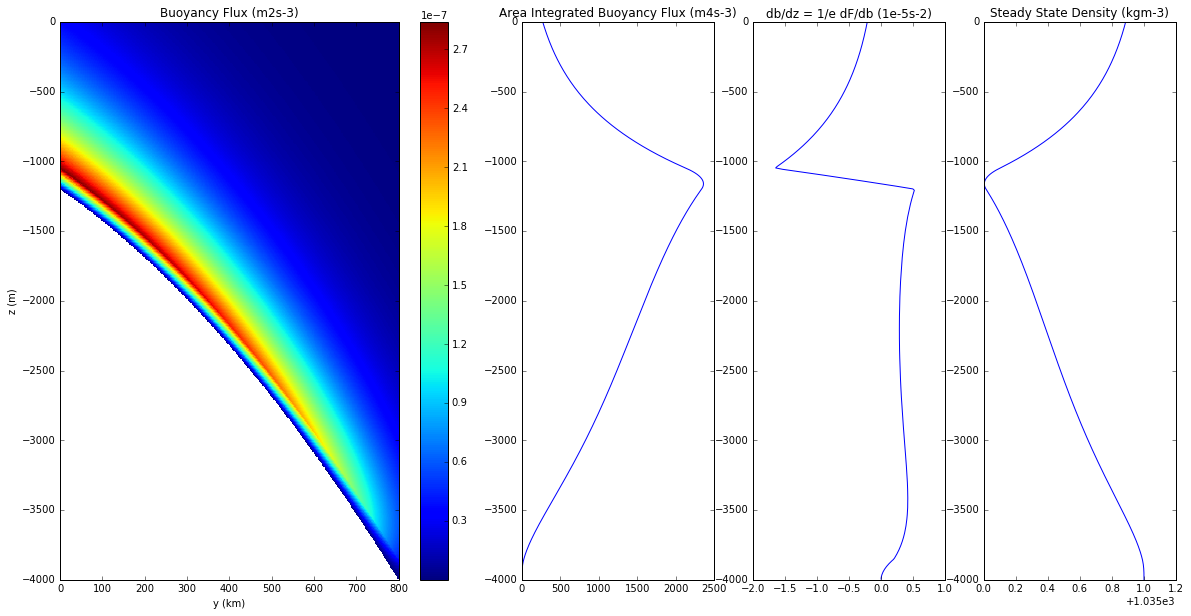

In [75]:
# Analytical Steady State Solution:
# Parameters:
B0 = 0.3e-6; hBL = 150.0; d = 500.0; r = 1000.0; eps = 0.25e6; rho0 = 1035.0; g = 9.81;
H = 4000; drho = 1.0; W = 40.0e3; L = 800.0e3; Ny = 1600; Nz = 400;
bwidth = 0.0; idepth=0.3; curv = 0.4;
# Analytical Grid:
y = np.linspace(0,L,Ny); z = np.linspace(-H,0,Nz); dy = y[1]-y[0]; dz = z[1]-z[0]
[Z,Y] = np.meshgrid(z,y); [yLa, zLa] = np.shape(Y)
# Topography:
yb = 1.0-bwidth; ah = idepth*H; ch = curv*(H-ah)/yb/yb; bh = (H-ah-ch*yb*yb)/yb;
h = np.zeros(np.shape(y)); h[y/L>=yb] = H; h[y/L<yb] = ah + bh*y[y/L<yb]/L + ch/L/L*np.power(y[y/L<yb],2); h = -h
h2D = np.tile(h,[zLa,1]).T
# Buoyancy Flux:
B = np.ma.zeros(np.shape(Y))
B[np.logical_and(Z>=h2D,Z<=h2D+hBL)] = B0*(Z[np.logical_and(Z>=h2D,Z<=h2D+hBL)]-h2D[np.logical_and(Z>=h2D,Z<=h2D+hBL)])/hBL
B[Z>h2D+hBL] = B0*np.exp(-(Z[Z>h2D+hBL]-h2D[Z>h2D+hBL]-hBL)/d)
B = B*(1-np.exp(-(Z+H)/r)); B = np.ma.masked_where(Z<=h2D,B)
# Area Integrated B, dbdz, drhodz, rho:
F = np.ma.sum(B,axis=0)*dy*W; F[0]=0.0; F.mask[0] = False; dbdz = np.ma.diff(F)/dz/eps; drhodz = -rho0/g*dbdz
rho = np.zeros(np.shape(z)); rho[0] = rho0+drho; rho[1:] = np.cumsum(drhodz)*dz+rho[0]
# Plotting:
f = plt.figure(figsize=(20,10))
plt.subplot2grid((1,5),(0,0), colspan=2);
plt.pcolormesh(Y/1e3,Z,B);plt.xlabel('y (km)');plt.ylabel('z (m)');plt.title('Buoyancy Flux (m2s-3)');plt.colorbar()
plt.subplot(1,5,3);plt.plot(F,z);plt.title('Area Integrated Buoyancy Flux (m4s-3)');
plt.subplot(1,5,4);plt.plot(dbdz/1.0e-5,(z[:-1]+z[1:])/2);plt.title('db/dz = 1/e dF/db (1e-5s-2)');
plt.subplot(1,5,5);plt.plot(rho,z);plt.title('Steady State Density (kgm-3)');
#plt.savefig('steady5krun_analytic')

In [76]:
# Line plots Analytical Solution next to full Solution and expected Solution:
record = -1;
e = fname.variables['e'][record,:,:,0]; B = fname.variables['buoyancy_flux'][record,:,:,0];
dyr = (yq[1]-yq[0])*1e3
#Interpolate onto z-points:
rho_z = np.zeros((yL,Nz));B_z = np.zeros((yL,Nz))
for i in range(yL):
    f = interp.interp1d(e[:,i],rhoi,bounds_error=False, fill_value=nan)
    rho_z[i,:] = f(z)
    f = interp.interp1d((e[1:,i]+e[:-1,i])/2,B[:,i],bounds_error=False, fill_value=nan)
    B_z[i,:] = f(z)

# Area Integrated B, dbdz, drhodz, rho:
F_z = np.nansum(B_z,axis=0)*dyr*W/4;
dbdz_e = np.ma.diff(F_z)/dz/eps; drhodz_e = -rho0/g*dbdz_e
rho_e = np.zeros(np.shape(z)); rho_e[0] = rho0+drho; rho_e[1:] = np.cumsum(drhodz_e)*dz+rho_e[0]
rho_z = moving_average(np.nanmean(rho_z,axis=0),n=9)
dbdz_z = moving_average(-g/rho0*np.diff(rho_z)/dz,n=11)
rho_e = moving_average(rho_e,n=31)
dbdz_e = moving_average(dbdz_e,n=31)
F_z = moving_average(F_z,n=9)

f = plt.figure(figsize=(15,10))
plt.subplot(1,3,1);
plt.plot(F,z, label='Input');
plt.plot(F_z,z, label='Simulated')
plt.title('Area Integrated Buoyancy Flux (m4s-3)');plt.legend();
plt.subplot(1,3,2);
plt.plot(rho,z, label='Analytic');
plt.plot(rho_z,z, label='Simulated');
plt.plot(rho_e,z, label='Expected from simulated F');
plt.title('Steady State Density (kgm-3)');plt.legend();
plt.subplot(1,3,3);
plt.plot(dbdz/1.0e-5,(z[:-1]+z[1:])/2, label='Analytic');
plt.plot(dbdz_z/1.0e-5,(z[:-1]+z[1:])/2, label='Simulated');
plt.plot(dbdz_e/1.0e-5,(z[:-1]+z[1:])/2, label='Expected from simulated F');
plt.title('db/dz');plt.legend();plt.xlim([0., 1]);
#plt.savefig('steady5krun_analyticComp')

/home/z3500785/anaconda3/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


TypeError: 'float' object cannot be interpreted as an integer

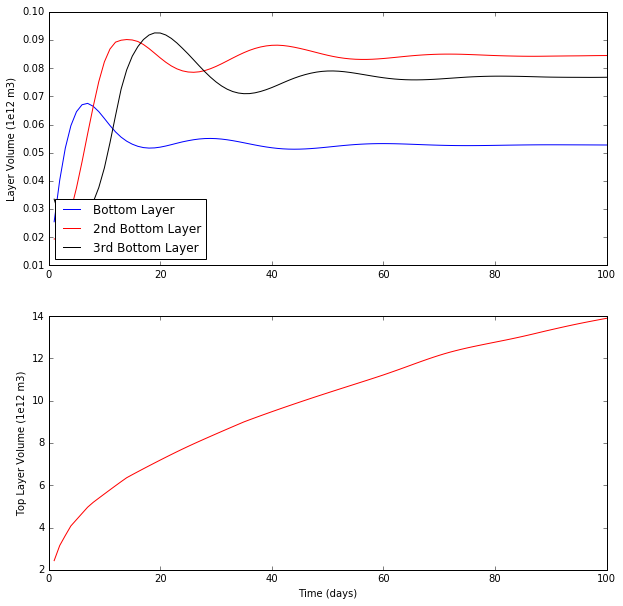

In [78]:
#Total mass and volume:
h = fname.variables['h'][:,:,:,0]
tvol = fname.variables['volo'][:]
tmass = fname.variables['masso'][:]
volume = np.dot(h,A[:,0])*len(A[0,:])
mass   = np.dot(np.dot(h,A[:,0]),rhol)*len(A[0,:])
time = fname.variables['Time'][:]
f = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(time,volume[:,-1]/1e12,'-b', label='Bottom Layer')
plt.plot(time,volume[:,-2]/1e12,'-r', label='2nd Bottom Layer')
plt.plot(time,volume[:,-3]/1e12,'-k', label='3rd Bottom Layer')
#plt.plot(time,volume[:,1]/1e12,'-m', label='2nd Top Layer')
plt.ylabel('Layer Volume (1e12 m3)')
#plt.ylim([0, 15])
plt.legend(loc=3)
plt.subplot(2,1,2)
plt.plot(time,volume[:,0]/1e12,'-r')
plt.ylabel('Top Layer Volume (1e12 m3)')
plt.xlabel('Time (days)')
#plt.savefig('steady5krun_trend')
#f2 = plt.figure(figsize=(10,5))
#plt.subplot(2,1,1)
#plt.plot(time,np.sum(volume,axis=1)/1e12,'-k')
#plt.plot(time,tvol/1e12,'-r')
#plt.ylabel('Total Volume (1e12 m3)')
#plt.subplot(2,1,2)
#plt.plot(time,mass/1e15,'-k')
#plt.plot(time,tmass/1e15,'-r')
#plt.ylabel('Total Mass (1e15 kg)')


In [79]:
yq

array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
         90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
        180.,  190.,  200.,  210.,  220.,  230.,  240.,  250.,  260.,
        270.,  280.,  290.,  300.,  310.,  320.,  330.,  340.,  350.,
        360.,  370.,  380.,  390.,  400.,  410.,  420.,  430.,  440.,
        450.,  460.,  470.,  480.,  490.,  500.,  510.,  520.,  530.,
        540.,  550.,  560.,  570.,  580.,  590.,  600.,  610.,  620.,
        630.,  640.,  650.,  660.,  670.,  680.,  690.,  700.,  710.,
        720.,  730.,  740.,  750.,  760.,  770.,  780.,  790.,  800.])

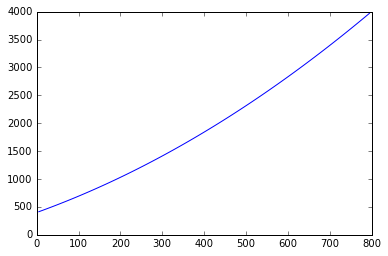

In [80]:
plt.plot(yh,bathyT)

In [81]:
yh

array([   5.,   15.,   25.,   35.,   45.,   55.,   65.,   75.,   85.,
         95.,  105.,  115.,  125.,  135.,  145.,  155.,  165.,  175.,
        185.,  195.,  205.,  215.,  225.,  235.,  245.,  255.,  265.,
        275.,  285.,  295.,  305.,  315.,  325.,  335.,  345.,  355.,
        365.,  375.,  385.,  395.,  405.,  415.,  425.,  435.,  445.,
        455.,  465.,  475.,  485.,  495.,  505.,  515.,  525.,  535.,
        545.,  555.,  565.,  575.,  585.,  595.,  605.,  615.,  625.,
        635.,  645.,  655.,  665.,  675.,  685.,  695.,  705.,  715.,
        725.,  735.,  745.,  755.,  765.,  775.,  785.,  795.])